# PyREx Demo

**PyREx is a python package designed for the simulation of in-ice radio detectors.** It started as a tool for exploring possibilities for adding radio antennas as an extension of IceCube (IceCube Radio Extension -> IREX -> PyREx), and has developed into a modular framework for radio array simulation. We are approaching parity with AraSim simulation results, while taking only 2-4x the time to run. This notebook was written to demonstrate the abilities and flexibility of the PyREx pacakge.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)

import pyrex
import pyrex.custom.ara as ara

## Table of Contents

[Example Code](#example_code)

[Event Kernel](#event_kernel)

[Particle Generators](#generators)

[Askaryan Signals](#askaryan_signals)

[Ray Tracer](#ray_tracer)

[Ice Model](#ice_model)

[Antennas](#antennas)

[Full Detectors](#detectors)

[Final Example](#final_example)

<a id='example_code'></a>
## Example Code
Let's start by demonstrating a sample simulation loop, and then we can explore its pieces bit-by-bit to demonstrate the individual parts of PyREx. In this example we take a known triggering event from AraSim and reproduce the waveform output.

First we'll set up a particle generator that will throw our given particle.

In [2]:
particle = pyrex.Particle(particle_id=pyrex.Particle.Type.electron_neutrino,
                          vertex=[9923.18, 8653.11, -560],
                          direction=[-0.56038081, 0.82752572, -0.03427129],
                          energy=1e10)
particle.interaction.em_frac = 0.950464
particle.interaction.had_frac = 0
generator = pyrex.ListGenerator(pyrex.Event(particle))

Then we'll set up an ARA station.

In [3]:
# Match the x, y offset in AraSim
detector = ara.RegularStation(x=9999.86, y=9999.86)
detector.build_antennas(power_threshold=-6.15)

And then we'll set up the kernel responsible for taking an event, propagating the signal, and passing it into the antennas of our detector.

In [4]:
kernel = pyrex.EventKernel(generator=generator,
                           antennas=detector)

So now we can throw the event ...

In [5]:
thrown_event = kernel.event()
particle = thrown_event.roots[0]
print(particle.id)
print(particle.energy)
print(particle.interaction.em_frac)

Type.electron_neutrino
10000000000.0
0.950464


... and check out the resulting waveforms.

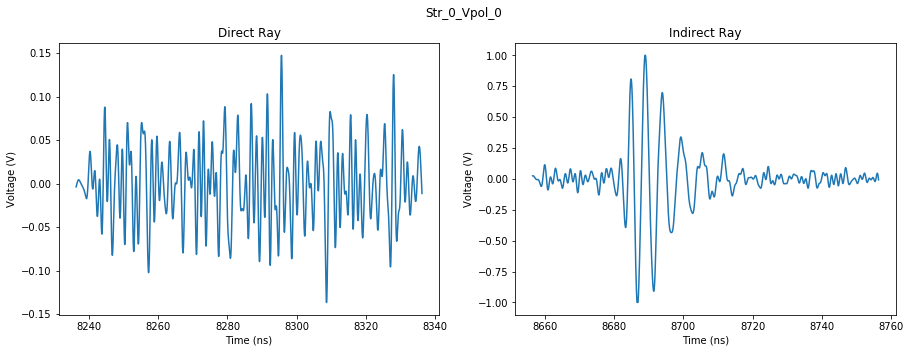

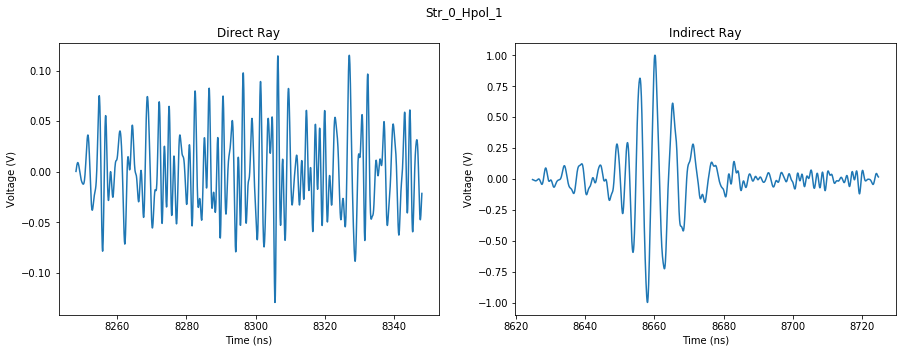

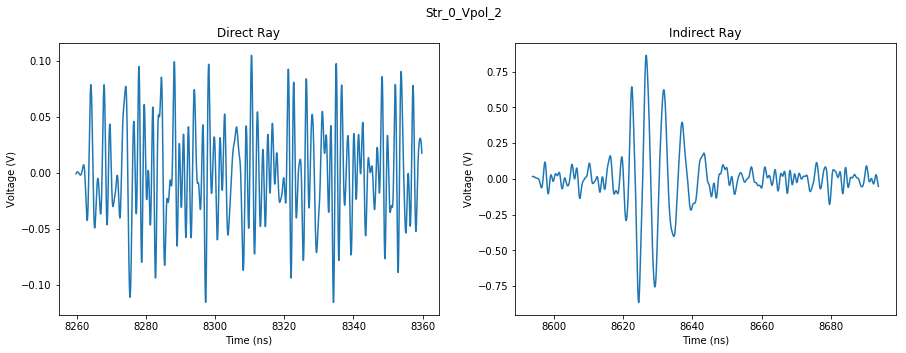

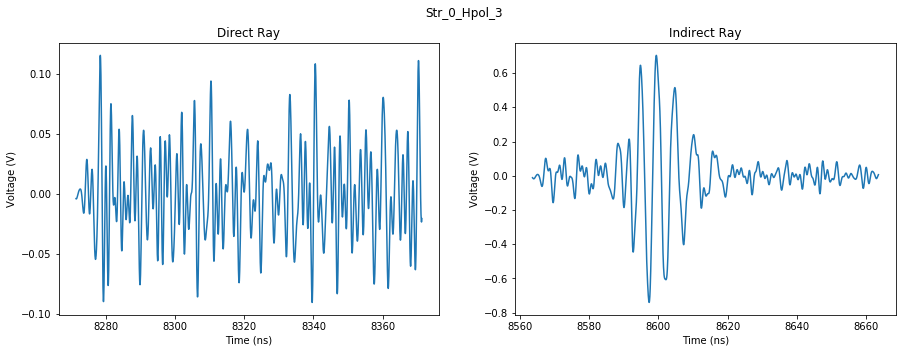

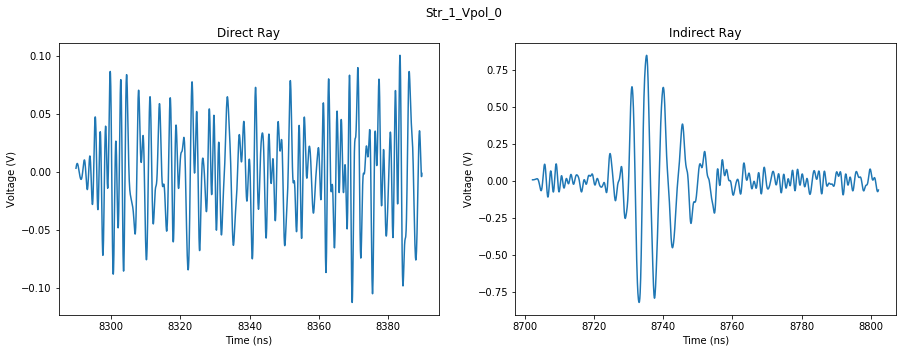

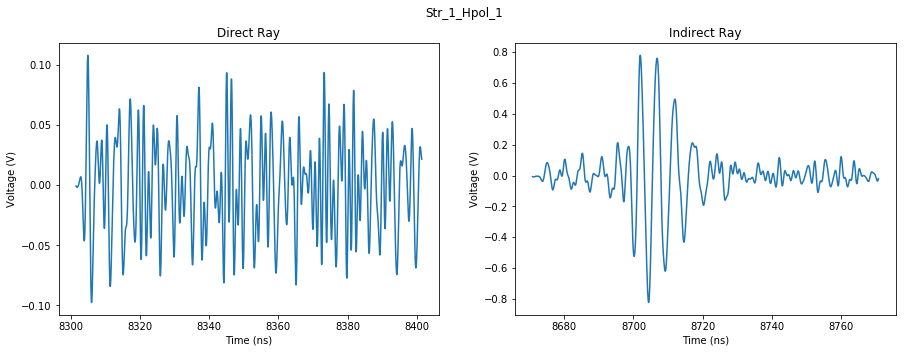

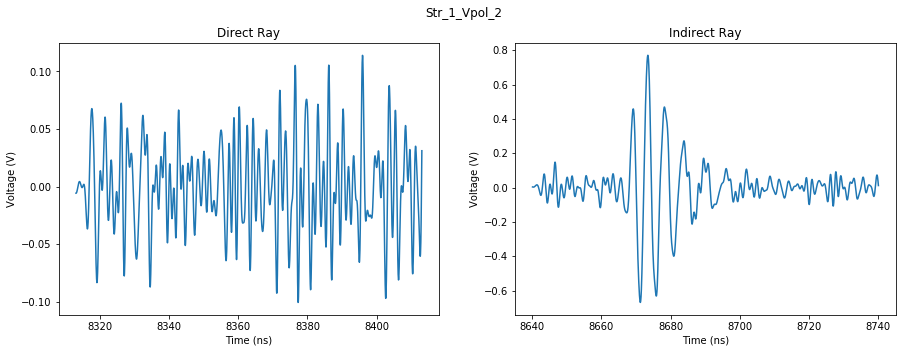

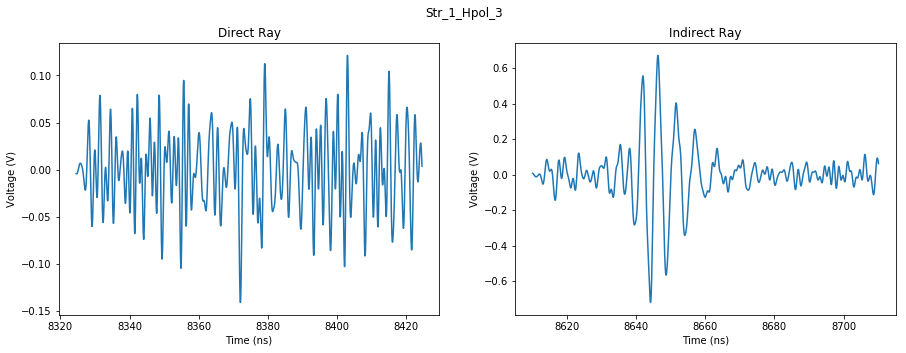

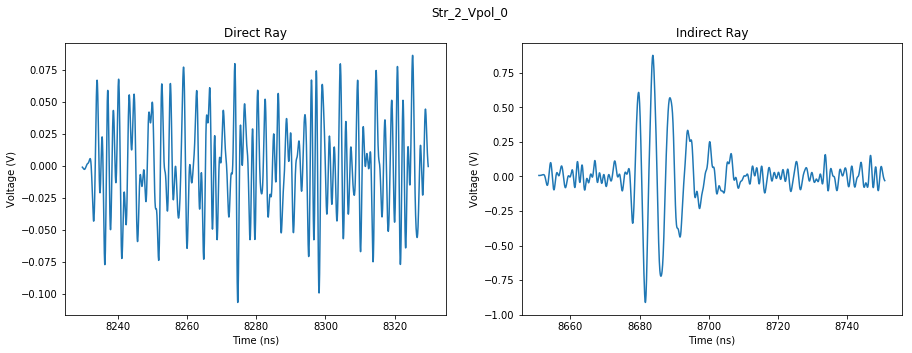

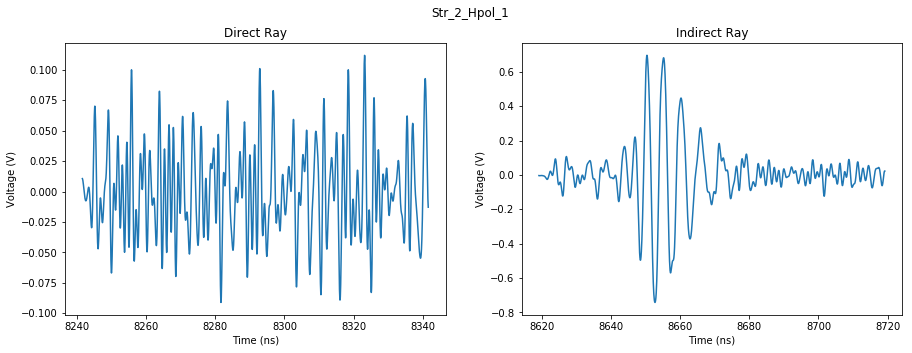

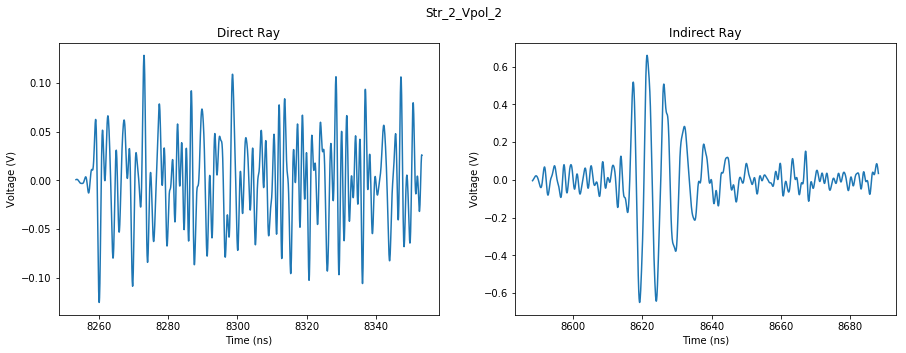

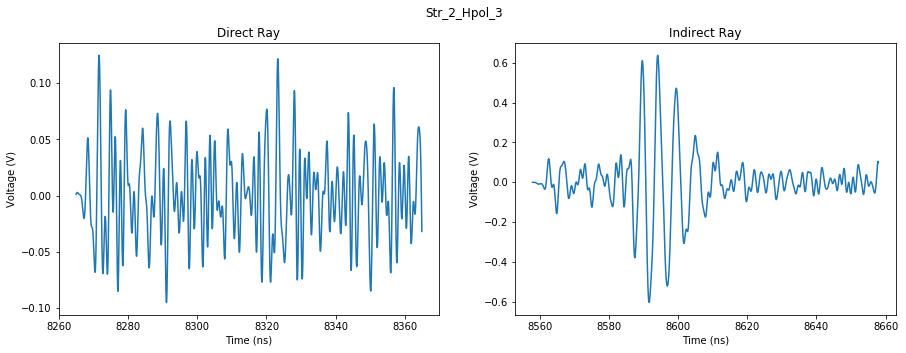

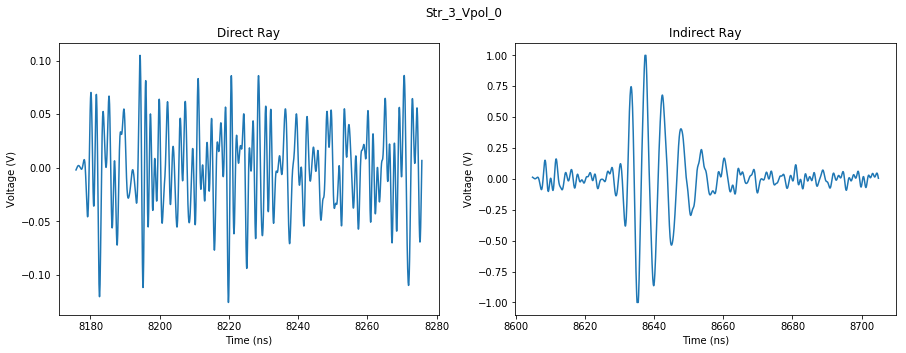

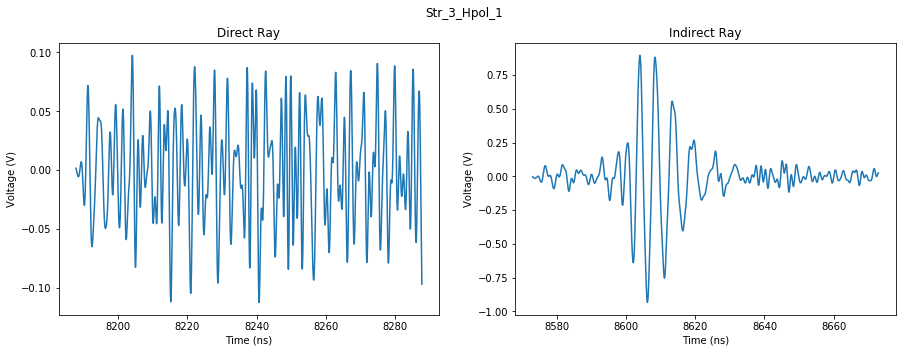

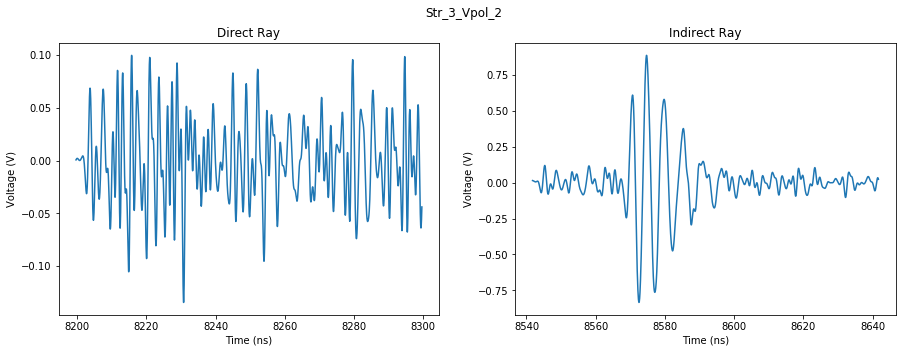

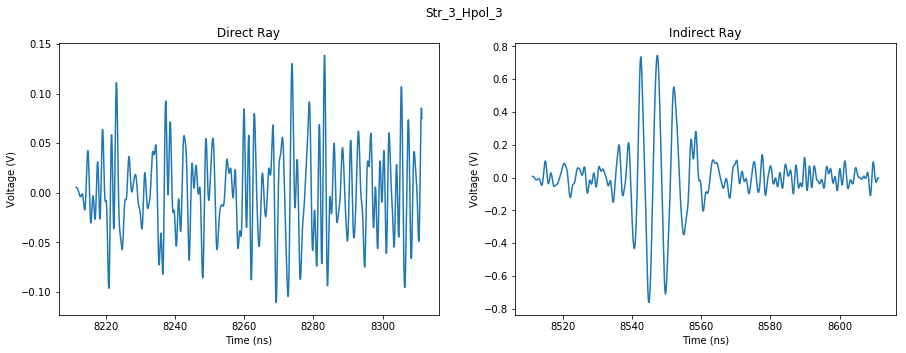

In [6]:
for i, ant in enumerate(detector):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    for j, waveform in enumerate(ant.all_waveforms):
        ax[j].plot(waveform.times * 1e9, waveform.values)
        title = "Direct Ray" if j==0 else "Indirect Ray"
        ax[j].set_title(title)
        ax[j].set_xlabel("Time (ns)")
        ax[j].set_ylabel("Voltage (V)")
    string = str(int(i/4))
    fig.suptitle("Str_"+string+"_"+ant.name)

<a id='event_kernel'></a>
## Event Kernel

To explore the way the simulation above works, let's start by looking at the ``EventKernel``. In PyREx the ``EventKernel`` class is the main simulation controller. It will produce particles based on a given particle generator and will handle sending their respective Askaryan pulses to a given set of antennas. The ``EventKernel`` can also be given specific ice model, ray tracer, and signal model classes to use.

In [7]:
kernel = pyrex.EventKernel(generator=generator,
                           antennas=detector,
                           ice_model=pyrex.IceModel,          # default
                           ray_tracer=pyrex.RayTracer,        # default
                           signal_model=pyrex.AskaryanSignal) # default

Calling the ``EventKernel.event`` method will prompt the given particle generator to produce a particle, then will create Askaryan pulses according to the signal model and propagate them to the positions of each antenna in the given set according to the given ice model and ray tracer, and then will prompt the antennas to process the signals according to their respective freqeuency/directional responses and electronics chains. The ``EventKernel.event`` method then returns an event object containing the particle object which was generated for the event.

In [8]:
thrown_event = kernel.event()
print(thrown_event)
print(thrown_event.roots)

Now let's take a closer look at each step in the event process and see how the pieces can be changed independently to change the behavior of the simulation.

<a id='generators'></a>
## Particle Generators
The first step of the simulation was particle generation. PyREx provides a couple particle generators to get started, and it's easy to write your own. The first and most used generator is the ``ShadowGenerator`` which generates particles in a rectangular section of ice, accounting for shadowing by the Earth. It can create particles with a constant energy or with energies obeying some function.

In [9]:
width = 1000 # m
depth = 1000 # m
energy_function = lambda: np.random.choice([1e7, 2e8, 3e9]) # GeV
generator = pyrex.ShadowGenerator(dx=width,
                                  dy=width,
                                  dz=depth,
                                  energy=energy_function)

The generator above will generate particles in a 1 km x 1 km x 1 km cube, with energies randomly chosen between 1e7, 2e8, and 3e9. To ask the generator to produce a particle, call the ``ShadowGenerator.create_particle`` method. In fact, if you create your own particle generator class this is the only required method. Let's check that the generator is working as expected by generating a few thousand particles and plotting their properties.

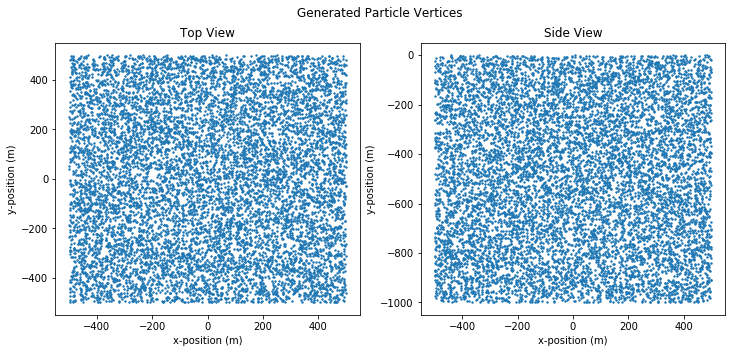

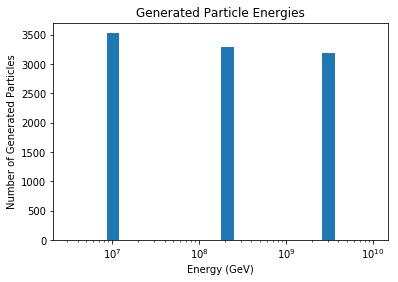

In [10]:
xs = []
ys = []
zs = []
energies = []
for _ in range(10000):
    event = generator.create_event()
    p = event.roots[0]
    xs.append(p.vertex[0])
    ys.append(p.vertex[1])
    zs.append(p.vertex[2])
    energies.append(p.energy)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(xs, ys, s=2)
ax[0].set_title("Top View")
ax[0].set_xlabel("x-position (m)")
ax[0].set_ylabel("y-position (m)")
ax[1].scatter(xs, zs, s=2)
ax[1].set_title("Side View")
ax[1].set_xlabel("x-position (m)")
ax[1].set_ylabel("y-position (m)")
fig.suptitle("Generated Particle Vertices")
plt.show()
plt.hist(energies, bins=np.logspace(6.5, 10, 25))
plt.gca().set_xscale('log')
plt.title("Generated Particle Energies")
plt.xlabel("Energy (GeV)")
plt.ylabel("Number of Generated Particles")
plt.show()

Another particle generator provided by PyREx is the ``ListGenerator``, used in the first example, which will pull particles (or a single particle) sequentially from a given list of particles. Additionally there is a ``FileGenerator`` which will pull sequentially from a numpy file (or many numpy files) containing lists of energies, vertices, and directions.

<a id='askaryan_signals'></a>
## Askaryan Signals

The next step in the simulation chain is signal generation. PyREx handles this in the ``AskaryanSignal`` class, which generates time-domian Askaryan pulses based on the parametrization of [Alvarez-Muñiz, Romero-Wolf, & Zas](https://arxiv.org/pdf/1106.6283v3.pdf). It makes use of convolutions to produce the waveform quickly.

In [11]:
time_array = np.linspace(0, 50e-9, 1001) # seconds
time_offset = 10e-9 # seconds
observation_angle = np.radians(50)
observation_distance = 1000 # m
particle_energy = 1e8 # GeV
neutrino = pyrex.Particle(particle_id="nu_e", vertex=(0, 0, -1000),
                          direction=(0, 0, -1), energy=particle_energy)
neutrino.interaction.em_frac = 1
neutrino.interaction.had_frac = 0
signal = pyrex.AskaryanSignal(times=time_array,
                              particle=neutrino,
                              viewing_angle=observation_angle,
                              viewing_distance=observation_distance,
                              t0=time_offset)

The signal is a PyREx ``Signal`` object, which has attributes for the times over which it is defined and the corresponding values.

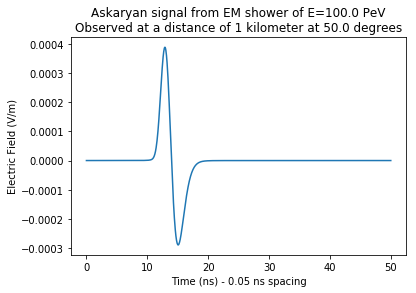

In [12]:
plt.plot(signal.times * 1e9, signal.values)
plt.title("Askaryan signal from EM shower of E="+str(particle_energy*1e-6)
          +" PeV\nObserved at a distance of 1 kilometer at "
          +str(np.degrees(observation_angle))+" degrees")
plt.xlabel("Time (ns) - "+str(round(signal.dt*1e9, 2))+" ns spacing")
plt.ylabel("Electric Field (V/m)")
plt.show()

The PyREx ``Signal`` class has a number of other attributes and methods, including frequency-domain representations and a method for applying frequency-domain filters.

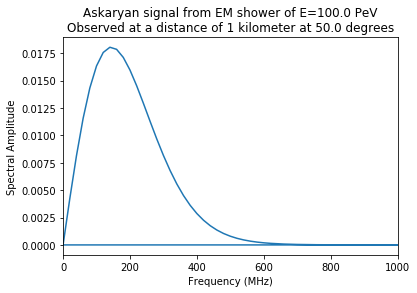

In [13]:
plt.plot(signal.frequencies / 1e6, np.abs(signal.spectrum))
plt.title("Askaryan signal from EM shower of E="+str(particle_energy*1e-6)
          +" PeV\nObserved at a distance of 1 kilometer at "
          +str(np.degrees(observation_angle))+" degrees")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Spectral Amplitude")
plt.xlim(0, 1e3)
plt.show()

<a id='ray_tracer'></a>
## Ray Tracer
The next step in the simulation chain is propagation of the signals to the antennas. This is handled by the PyREx ``RayTracer`` class, or any similar class passed to the ``EventKernel``. The default PyREx ray tracer performs full ray tracing with a nearly-analytical method (requires a root-finder in path determination and numerical integration for attenuation calculation). Additionally, it is decoupled from the ice model and only requires that the ice model's index of refraction take an exponential form.

In [14]:
shower_vertex = [-1000, -2000, -1000]
antenna_position = [0, 0, -100]
rt = pyrex.RayTracer(from_point=shower_vertex,
                     to_point=antenna_position,
                     ice_model=pyrex.IceModel)

The ``RayTracer`` checks whether paths exist between the two given points (``RayTracer.exists`` attribute), and if they do then the ``RayTracer.solutions`` attribute is a list of the two paths (direct and refracted/reflected) between the points. These ``RayTracePath`` objects have attributes for the launch and received directions, time of flight, path length, and attenuation along the path.

Path 1:
  Launch direction: [0.41149099 0.82298198 0.39163225]
  Received direction: [0.43987727 0.87975454 0.18038831]
  Time of Flight: 14.214953278747135 microseconds
  Path Length: 2412.6638475563723 meters
  Attenuation (300 MHz): 0.23900874671201894
Path 2:
  Launch direction: [0.39566676 0.79133352 0.46608913]
  Received direction: [ 0.42296142  0.84592284 -0.32483564]
  Time of Flight: 14.271183608191894 microseconds
  Path Length: 2463.5861225896647 meters
  Attenuation (300 MHz): 0.24260162193680837


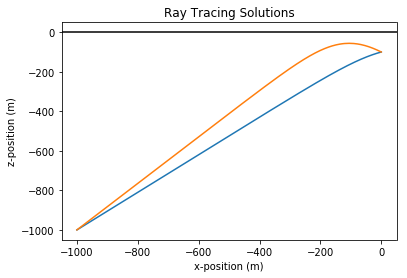

In [15]:
if rt.exists:
    for i, path in enumerate(rt.solutions):
        print("Path "+str(i+1)+":")
        print("  Launch direction:", path.emitted_direction)
        print("  Received direction:", path.received_direction)
        print("  Time of Flight:", path.tof*1e6, "microseconds")
        print("  Path Length:", path.path_length, "meters")
        print("  Attenuation (300 MHz):", float(path.attenuation(300e6)))
        plt.plot(path.coordinates[0], path.coordinates[2],
                 label="Path "+str(i+1))
    plt.axhline(0, c='k')
    plt.title("Ray Tracing Solutions")
    plt.xlabel("x-position (m)")
    plt.ylabel("z-position (m)")
    plt.show()
else:
    print("No ray tracing solution")

<a id='ice_model'></a>
## Ice Model
Since the ray paths will change in different ice models, the ``IceModel`` class is separate from the ray tracer and can be changed independently in the ``EventKernel``. PyREx includes a couple of ice models. The default ``IceModel`` is based on [Matt Newcomb's Ice Characteristics](https://icecube.wisc.edu/~mnewcomb/radio/) and has an exponential index of refraction.

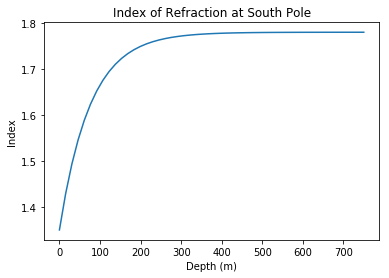

In [16]:
depths = np.linspace(0, 750)
plt.plot(depths, pyrex.IceModel.index(-depths))
plt.title("Index of Refraction at South Pole")
plt.xlabel("Depth (m)")
plt.ylabel("Index")
plt.show()

The default ``IceModel`` also uses [Dave Besson's Attenuation Lengths](https://icecube.wisc.edu/~mnewcomb/radio/atten/).

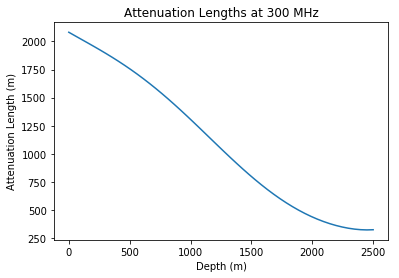

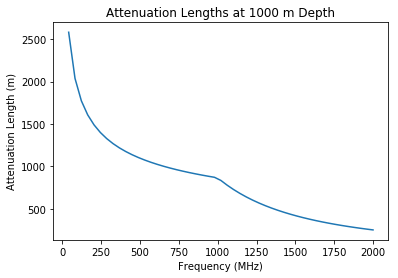

In [17]:
depths = np.linspace(0, 2500)
plt.plot(depths, pyrex.IceModel.attenuation_length(-depths, 300e6))
plt.title("Attenuation Lengths at 300 MHz")
plt.xlabel("Depth (m)")
plt.ylabel("Attenuation Length (m)")
plt.show()
freqs = np.linspace(0, 2e9)
plt.plot(freqs/1e6, pyrex.IceModel.attenuation_length(-1000, freqs))
plt.title("Attenuation Lengths at 1000 m Depth")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Attenuation Length (m)")
plt.show()

Additionally there is an ``ArasimIce`` model which mirrors the ice properties used in AraSim.

<a id='antennas'></a>
## Antennas

The final step in the simulation chain is the processing of signals by the antennas. PyREx provides an inheritable ``Antenna`` class which allows for variably customized antenna objects. The default ``Antenna`` class is fairly basic.

In [18]:
position = (0,0,-250) # m
frequency_range = (150e6, 750e6) # Hz
ant = pyrex.Antenna(position=position,
                    freq_range=frequency_range,
                    noise_rms=0.04)

The ``Antenna.is_hit`` property checks whether the antenna has been triggered.

In [19]:
print("ant.is_hit =", ant.is_hit)

ant.is_hit = False


The base antenna class will trigger on any signal, even a completely empty signal.

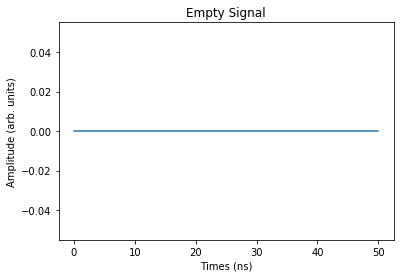

triggered = True


In [20]:
empty = pyrex.EmptySignal(times=np.linspace(0, 50e-9, 1001))
plt.plot(empty.times * 1e9, empty.values)
plt.title("Empty Signal")
plt.xlabel("Times (ns)")
plt.ylabel("Amplitude (arb. units)")
plt.show()
print("triggered =", ant.trigger(empty))

But it is easy to make an antenna class with a different trigger condition.

In [21]:
class ThresholdAntenna(pyrex.Antenna):
    def __init__(self, *args, trigger_threshold=0, **kwargs):
        super().__init__(*args, **kwargs)
        self.threshold=trigger_threshold
        
    def trigger(self, signal):
        return np.max(np.abs(signal.values))>self.threshold

In [22]:
th_ant = ThresholdAntenna(position=position,
                          freq_range=frequency_range,
                          noise_rms=0.04,
                          trigger_threshold=0.25)

In [23]:
print("triggered =", th_ant.trigger(empty))

triggered = False


When an ``Antenna`` receives a ``Signal`` object, it processes it according to the antenna's frequency response (the default frequency response being flat) and then adds it to the antenna.signals array. The full waveforms (including noise) of all events the antenna has received are available as the antenna.all_waveforms array.

len(ant.signals) before = 0
len(ant.signals) after = 1


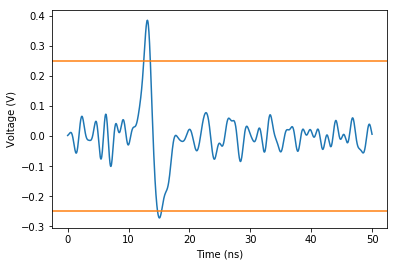

triggered = True


In [24]:
print("len(ant.signals) before =",len(th_ant.signals))
neutrino = pyrex.Particle(particle_id="nu_e", vertex=(0, 0, -1000),
                          direction=(0, 0, -1), energy=1e8)
neutrino.interaction.em_frac = 1
neutrino.interaction.had_frac = 0
signal = pyrex.AskaryanSignal(times=np.linspace(0, 50e-9, 1001),
                              particle=neutrino,
                              viewing_angle=np.radians(50),
                              viewing_distance=1,
                              t0=10e-9)
th_ant.receive(signal)
print("len(ant.signals) after =",len(th_ant.signals))
for w in th_ant.all_waveforms:
    plt.figure()
    plt.plot(w.times * 1e9, w.values)
    plt.axhline(th_ant.threshold, c='C1')
    plt.axhline(-th_ant.threshold, c='C1')
    plt.xlabel("Time (ns)")
    plt.ylabel("Voltage (V)")
    plt.show()
print("triggered =", th_ant.is_hit)

Many easy changes are possible by inheriting from the ``Antenna`` class. Similarly to overriding the ``trigger`` method above to change the trigger condition of the antenna, a number of functions can be easily overridden to change antenna behavior. These include ``make_noise`` which controls how noise is handled for the antenna, ``directional_gain`` which handles the directionality of the antenna, ``polarization_gain`` which controls how the antenna deals with signal polarization, ``response`` which handles the antenna's frequency response, and more.

<a id='detectors'></a>
## Full Detectors
In the first example, we used a custom-defined detector which created an ARA station for us. This detector inherits from the PyREx ``Detector`` class, which is a base class that can be used to quickly create sets of antennas.

In [25]:
detector = ara.RegularStation(x=0, y=0)
detector.build_antennas(power_threshold=-6.15)

Iterating over this object acts like iterating over a list of its antennas, which is exactly how it is used in the ``EventKernel``. This means if you wanted you could simply pass ``EventKernel`` a list of ``Antenna`` objects as your detector.

In [26]:
for ant in detector:
    print(type(ant))

<class 'pyrex.custom.ara.antenna.VpolAntenna'>
<class 'pyrex.custom.ara.antenna.HpolAntenna'>
<class 'pyrex.custom.ara.antenna.VpolAntenna'>
<class 'pyrex.custom.ara.antenna.HpolAntenna'>
<class 'pyrex.custom.ara.antenna.VpolAntenna'>
<class 'pyrex.custom.ara.antenna.HpolAntenna'>
<class 'pyrex.custom.ara.antenna.VpolAntenna'>
<class 'pyrex.custom.ara.antenna.HpolAntenna'>
<class 'pyrex.custom.ara.antenna.VpolAntenna'>
<class 'pyrex.custom.ara.antenna.HpolAntenna'>
<class 'pyrex.custom.ara.antenna.VpolAntenna'>
<class 'pyrex.custom.ara.antenna.HpolAntenna'>
<class 'pyrex.custom.ara.antenna.VpolAntenna'>
<class 'pyrex.custom.ara.antenna.HpolAntenna'>
<class 'pyrex.custom.ara.antenna.VpolAntenna'>
<class 'pyrex.custom.ara.antenna.HpolAntenna'>


We see that this ARA station is made up of ``VpolAntenna``s and ``HpolAntenna``s. These classes are derived from the PyREx ``AntennaSystem`` class, which is a class allowing for the combination of an ``Antenna`` object with some electronics front-end. This is how we apply the ARA electronics chain for each antenna, via the ``AntennaSystem.front_end`` method.

<a id='final_example'></a>
## Final Example

Now as a final example let's run another simulation similar to the first, but to show off the modularity of PyREx let's change out the particle generator, the ice model, and the detector.

For our particle generator, we'll use the ``ShadowGenerator`` with a cubic-kilometer volume and a constant energy.

In [27]:
width = 1000 # m
depth = 1000 # m
generator = pyrex.ShadowGenerator(dx=width,
                                  dy=width,
                                  dz=depth,
                                  energy=1e10)

For our detector let's make a string of ``ThresholdAntenna``s as defined above, and just pass them as a list to the ``EventKernel``.

In [28]:
class ThresholdAntenna(pyrex.Antenna):
    def __init__(self, *args, trigger_threshold=0, **kwargs):
        super().__init__(*args, **kwargs)
        self.threshold=trigger_threshold
        
    def trigger(self, signal):
        return np.max(np.abs(signal.values))>self.threshold

In [29]:
detector = [
    ThresholdAntenna(position=(0, 0, z),
                     freq_range=(150e6, 750e6),
                     noise_rms=0.04,
                     trigger_threshold=0.25)
    for z in (-25, -50, -75, -100)
]

And for our ice model, let's use the ``ArasimIce`` model, but we'll keep the default ``RayTracer`` and ``AskaryanSignal``.

In [30]:
kernel = pyrex.EventKernel(generator=generator,
                           antennas=detector,
                           ice_model=pyrex.ice_model.ArasimIce,
                           ray_tracer=pyrex.RayTracer,
                           signal_model=pyrex.AskaryanSignal)

Now let's make events until we see at least two antennas hit.

In [31]:
triggered = False
i = 0
while not triggered:
    i += 1
    for ant in detector:
        # Clear out the received waveforms from the last event
        ant.clear()
    event = kernel.event()
    triggered = sum(ant.is_hit for ant in detector) >= 2
print("Triggered after", i, "events")
print("Triggering neutrino:")
particle = event.roots[0]
print("  type =", particle.id)
print("  vertex =", particle.vertex)
print("  direction =", particle.direction)
print("  interaction =", particle.interaction.kind)
print("  electromagnetic fraction =", particle.interaction.em_frac)
print("  hadronic fraction =", particle.interaction.had_frac)
print("  weight =", particle.weight)

Triggered after 263 events
Triggering neutrino:
  type = Type.muon_neutrino
  vertex = [ 246.52647595  274.61020841 -118.4567155 ]
  direction = [-0.52836057 -0.80661938 -0.26495336]
  interaction = Type.neutral_current
  electromagnetic fraction = 0
  hadronic fraction = 0.9292324834387763
  weight = 6.814679159292278e-06


And now plot the antenna waveforms.

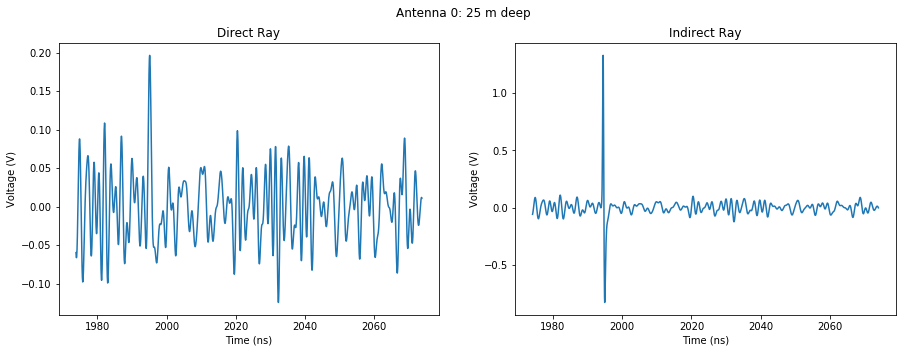

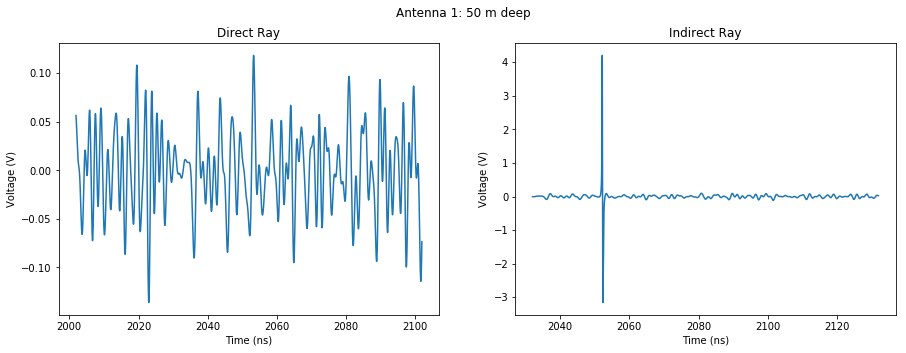

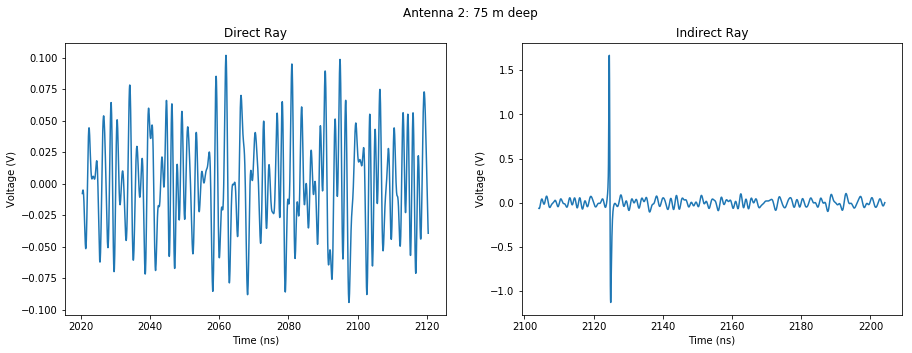

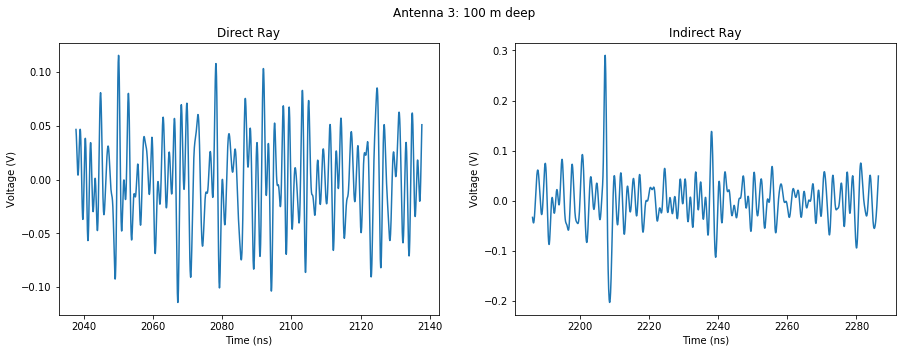

In [32]:
for i, ant in enumerate(detector):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    for j, waveform in enumerate(ant.all_waveforms):
        ax[j].plot(waveform.times * 1e9, waveform.values)
        title = "Direct Ray" if j==0 else "Indirect Ray"
        ax[j].set_title(title)
        ax[j].set_xlabel("Time (ns)")
        ax[j].set_ylabel("Voltage (V)")
    string = str(int(i/4))
    fig.suptitle("Antenna "+str(i)+": "+str(-ant.position[2])+" m deep")